<a href="https://colab.research.google.com/github/skamranh/big-data-final/blob/main/Cardio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Juan Gallegos, Syed Kamran, Creed Abell


## 1. Problem Statement:
 To predict whether patient, based on his medical and general records, has cardiovascular disease or not. This project will not replace current methods of evaluating caridovascular disease but just to compliment and increase accuracy of them.



## 2. Objective:
 Building a model to predict presence of cardiovascular disease or not. F-1 score should be matched and evaluated for best model and least False Negatives, in favor of False postives.

## 3. Dataset Information (Description of each Column):
There are 3 types of input features:

Objective: factual information;
Examination: results of medical examination;
Subjective: information given by the patient.
Features:

- Age | Objective Feature | age | int (days)
- Height | Objective Feature | height | int (cm) |
- Weight | Objective Feature | weight | float (kg) |
- Gender | Objective Feature | gender | categorical code |
- Systolic blood pressure | Examination Feature | ap_hi | int |
- Diastolic blood pressure | Examination Feature | ap_lo | int |
- Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: - well above normal |
- Smoking | Subjective Feature | smoke | binary |
- Alcohol intake | Subjective Feature | alco | binary |
- Physical activity | Subjective Feature | active | binary |
- Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.
# Reference
- https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset

## 4. Importing Libraries

In [1]:
!pip install pyspark
!pip install -q findspark

import pyspark
import findspark
findspark.init()
from pyspark.sql import SparkSession

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline 
import seaborn as sns
import pyspark.pandas as ps

import warnings

from pyspark.ml.feature import StandardScaler

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.classification import GBTClassifier

from pyspark.ml.classification import RandomForestClassifier

spark = SparkSession.builder.appName('wine').getOrCreate()

     |████████████████████████████████| 281.4 MB 26 kB/s 
     |████████████████████████████████| 198 kB 49.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=65d8998918c55a0bde93baaaeb45505bfb2c7da01e5c53dc855ef01faa82a080
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


## 5. Loading Dataset(s)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# dataset_loc = "data/cardio.csv"
dataset_loc = "/content/drive/MyDrive/Dataset/cardio.csv"
cardio_spark = spark.read.csv(dataset_loc, header="true", inferSchema=True, sep=";").drop("id")
cardio_pd = pd.read_csv(dataset_loc, sep=";").drop("id", 1)
cardio_ps = ps.read_csv(dataset_loc, sep=";").drop("id")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  after removing the cwd from sys.path.


## 6. Viewing the Head and Tail of the Dataset (first and last 5 rows)
- Starting from this section, at the end of each section, list 2-3 of your observations 

In [27]:
cardio_spark.show(5)

+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|18393|     2|   168|  62.0|  110|   80|          1|   1|    0|   0|     1|     0|
|20228|     1|   156|  85.0|  140|   90|          3|   1|    0|   0|     1|     1|
|18857|     1|   165|  64.0|  130|   70|          3|   1|    0|   0|     0|     1|
|17623|     2|   169|  82.0|  150|  100|          1|   1|    0|   0|     1|     1|
|17474|     1|   156|  56.0|  100|   60|          1|   1|    0|   0|     0|     0|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 5 rows



In [28]:
cardio_spark.orderBy("id", ascending=False).show(5)

+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|  age|gender|height|weight|ap_hi|ap_lo|cholesterol|gluc|smoke|alco|active|cardio|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
|20540|     1|   170|  72.0|  120|   80|          2|   1|    0|   0|     1|     0|
|22431|     1|   163|  72.0|  135|   80|          1|   2|    0|   0|     0|     1|
|19066|     2|   183| 105.0|  180|   90|          3|   1|    0|   1|     0|     1|
|22601|     1|   158| 126.0|  140|   90|          2|   2|    0|   0|     1|     1|
|19240|     2|   168|  76.0|  120|   80|          1|   1|    1|   0|     1|     0|
+-----+------+------+------+-----+-----+-----------+----+-----+----+------+------+
only showing top 5 rows



### Observation
- There is an ID column that is not needed and must be dropped.

## 7. Examining the Shape of the Dataset

In [29]:
print((cardio_spark.count(), len(cardio_spark.columns)))

(70000, 12)


### Observation
- There are 700000 rows and 13 columns

## 8. Checking the Data Types (dtype of each column)

In [30]:
cardio_ps.info()

<class 'pyspark.pandas.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int32  
 1   gender       70000 non-null  int32  
 2   height       70000 non-null  int32  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int32  
 5   ap_lo        70000 non-null  int32  
 6   cholesterol  70000 non-null  int32  
 7   gluc         70000 non-null  int32  
 8   smoke        70000 non-null  int32  
 9   alco         70000 non-null  int32  
 10  active       70000 non-null  int32  
 11  cardio       70000 non-null  int32  
dtypes: float64(1), int32(11)

In [31]:
cardio_spark.printSchema()

root
 |-- age: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- height: integer (nullable = true)
 |-- weight: double (nullable = true)
 |-- ap_hi: integer (nullable = true)
 |-- ap_lo: integer (nullable = true)
 |-- cholesterol: integer (nullable = true)
 |-- gluc: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- alco: integer (nullable = true)
 |-- active: integer (nullable = true)
 |-- cardio: integer (nullable = true)



### Observations
- There are no null values
- All Features are of numeric type

## 9. Viewing the Statistical Summary of the Dataset

In [32]:
cardio_spark.describe().show()

+-------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+
|summary|               age|             gender|            height|            weight|            ap_hi|             ap_lo|       cholesterol|              gluc|              smoke|                alco|            active|            cardio|
+-------+------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+
|  count|             70000|              70000|             70000|             70000|            70000|             70000|             70000|             70000|              70000|               70000|             70000|             70000|
|   mean|19468.865814285713| 1.34957

In [33]:
cardio_ps.describe().T

,count,mean,std,min,25%,50%,75%,max
age,70000.0,19468.865814,2467.251667,10798.0,17664.0,19703.0,21326.0,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.0,1.0,2.0,2.0
height,70000.0,164.359229,8.210126,55.0,159.0,165.0,170.0,250.0
weight,70000.0,74.205690,14.395757,10.0,65.0,72.0,82.0,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.0,120.0,140.0,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.0,80.0,90.0,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.0,1.0,2.0,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.0,1.0,1.0,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.0,0.0,0.0,1.0
alco,70000.0,0.053771,0.225568,0.0,0.0,0.0,0.0,1.0


## 10. EDA


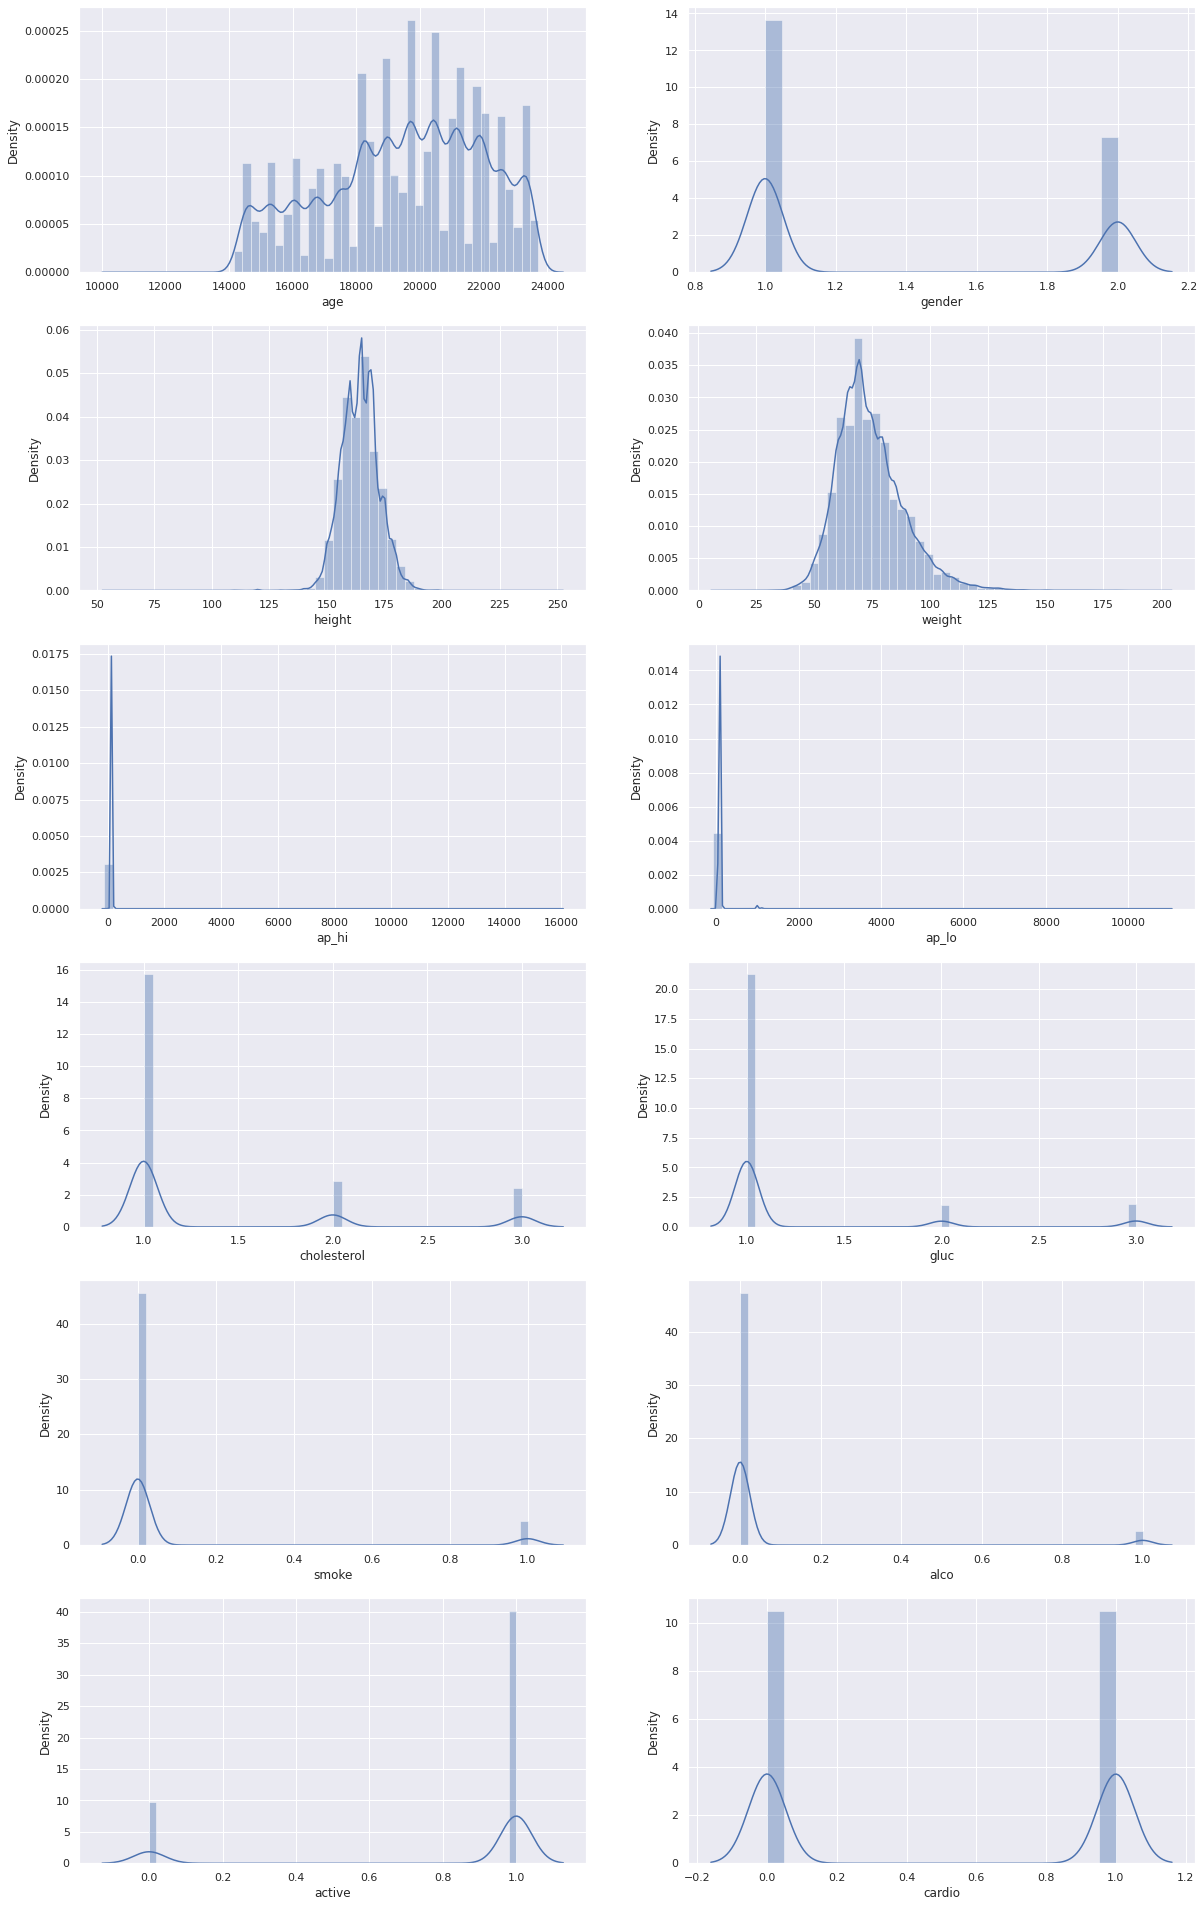

In [35]:
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [20, 40]
for i, column in enumerate(cardio_pd.columns, 1):
    plt.subplot(7,2,i)
    sns.distplot(cardio_pd[column])

### Univariate observation
- `ap_hi` and `ap_lo` are highly skewed and domain expert needs to validate whether these higher values are valid.
- `Glucose` levels are not normally distributed.
- `alc` represents whether patient is alchoholic or not, and is highly skewed.
- `smoke` is also skewed for non smokers.
- `active` is also skewed.

`These skewed fields may produce  biased model`

### Multivariate Analysis


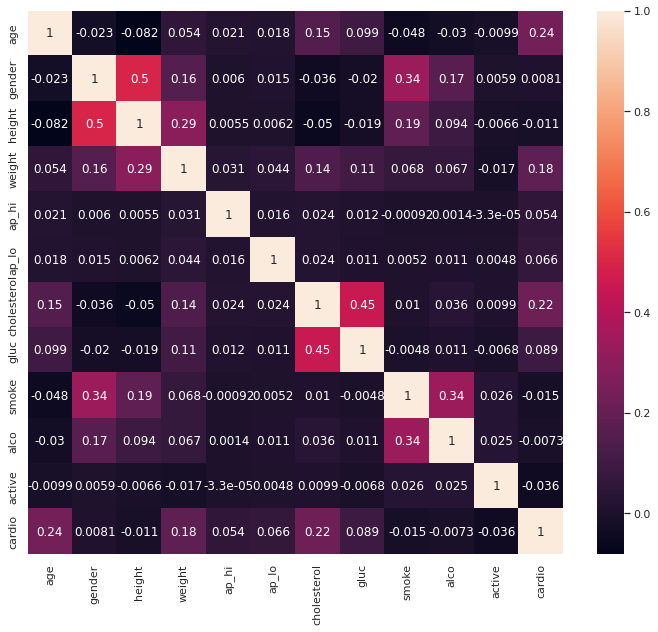

In [36]:
plt.rcParams['figure.figsize'] = [12, 10]
sns.set(font_scale = 1)
sns.heatmap(cardio_pd.corr(), annot = True)

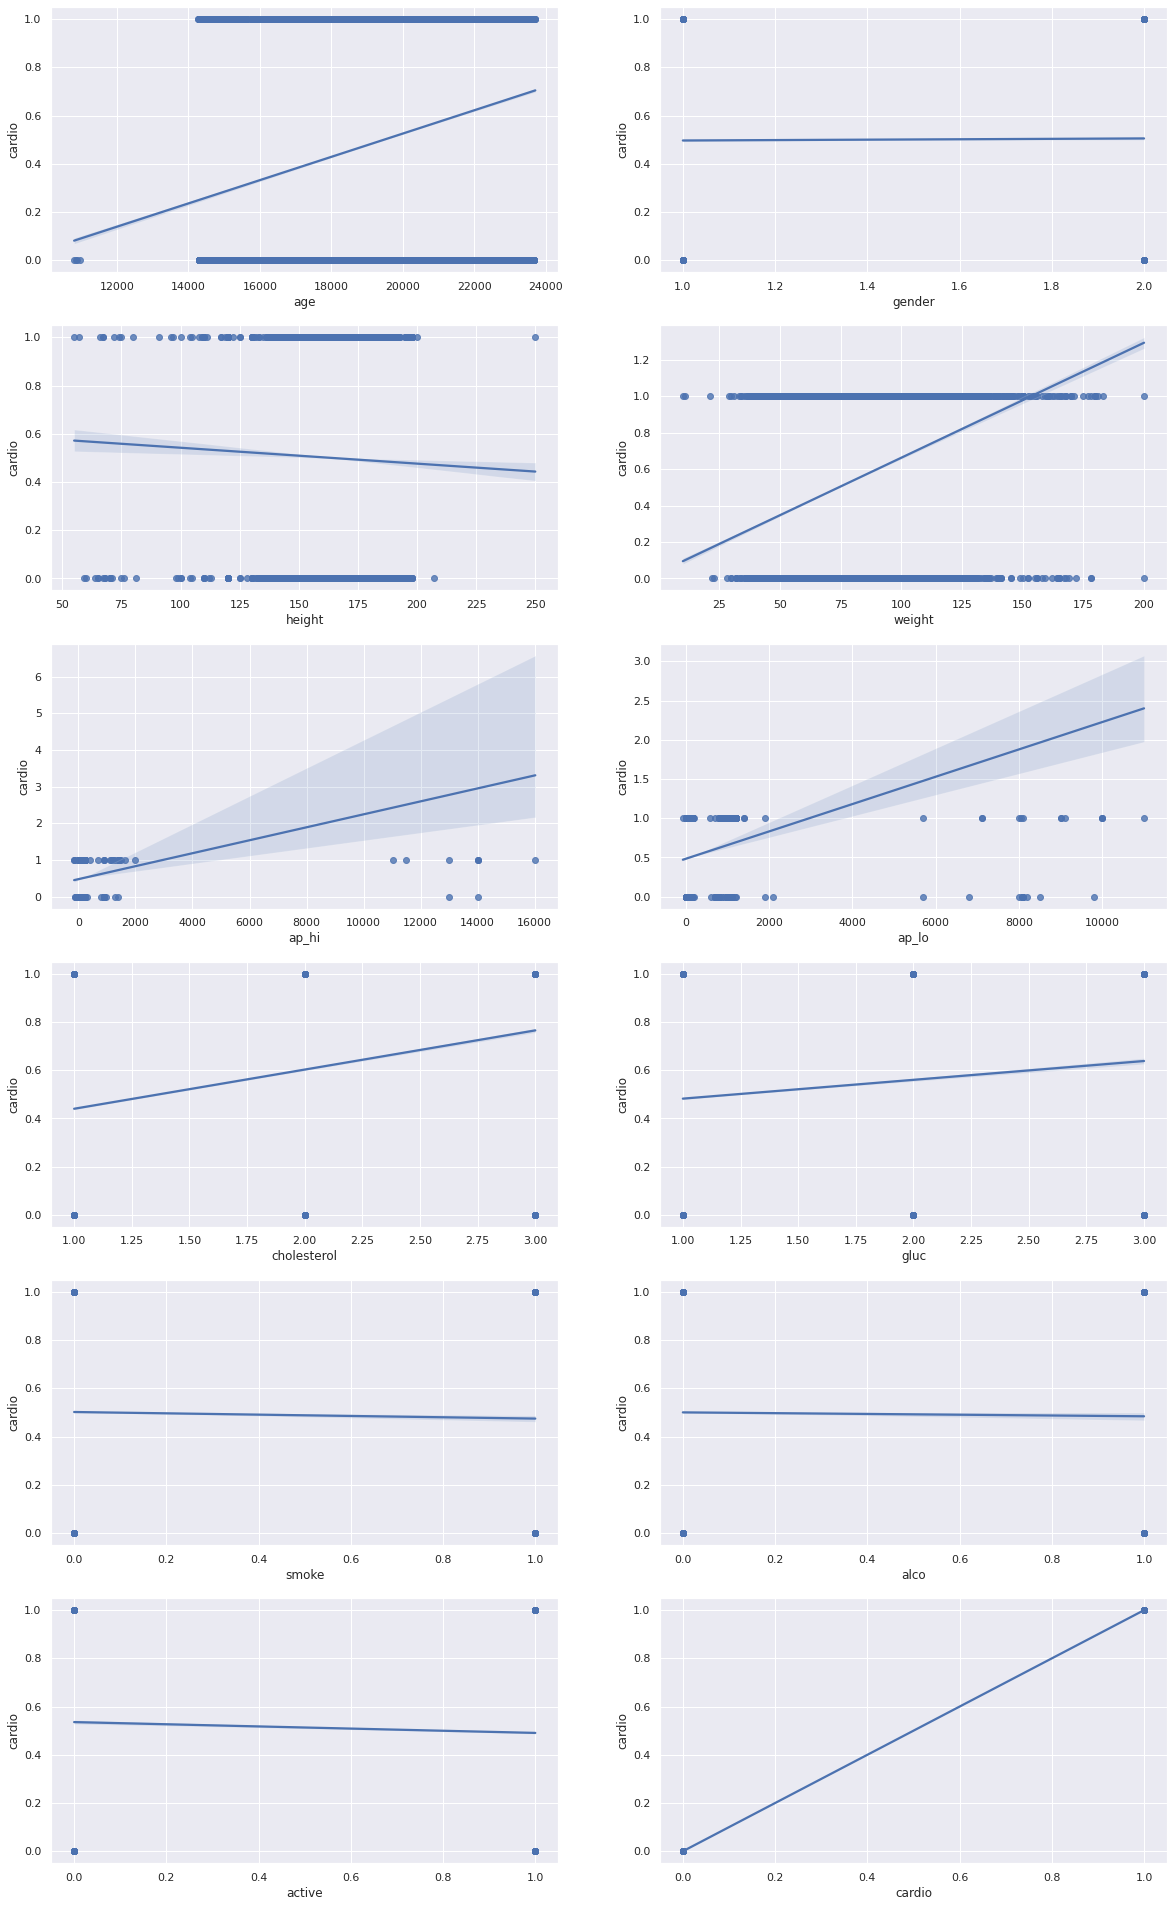

In [37]:
plt.rcParams['figure.figsize'] = [20, 40]

for i, column in enumerate(cardio_pd.columns, 1):
    plt.subplot(7,2,i)
    sns.regplot(x=cardio_pd[column],y=cardio_pd['cardio'], fit_reg=True)

# Logistic Regression(Without Feature Scaler)

In [38]:
feature_columns = cardio_spark.columns[:-1] # here we omit the final column

#Feature Selection
assembler = VectorAssembler(inputCols=feature_columns,outputCol="features")
cardio_spark2 = assembler.transform(cardio_spark)
# chd_spark2.show()

#Split
train, test = cardio_spark2.randomSplit([0.7, 0.3])

#model Definition
algo = LogisticRegression(
    featuresCol="features", 
    labelCol="cardio",
    maxIter=10)

#Training
model = algo.fit(train)

#Evaluation
training_summary = model.evaluate(train) 
evaluation_summary = model.evaluate(test)


print("Coefficients: " + str(model.coefficients))
print("Intercept: " + str(model.intercept))
print("Accuracy(Train): " + str(training_summary.accuracy))
print("Accuracy(Test): " + str(evaluation_summary.accuracy))

Coefficients: [0.00014733554211020632,-0.032686910066921884,-0.0025923125534602393,0.01396505762133907,0.04219984052480198,0.0004093890959826063,0.4585383449902385,-0.08024634586928313,-0.10610784265313553,-0.12508172882416774,-0.18262742968143392]
Intercept: -9.158829488307555
Accuracy(Train): 0.7220485791914363
Accuracy(Test): 0.7228371894151742


In [39]:
# predictions = model.transform(test)
feature_columns

['age',
 'gender',
 'height',
 'weight',
 'ap_hi',
 'ap_lo',
 'cholesterol',
 'gluc',
 'smoke',
 'alco',
 'active']

In [40]:
# trainingSummary = model.summary

# # Obtain the objective per iteration
# objectiveHistory = trainingSummary.objectiveHistory
# print("objectiveHistory:")
# for objective in objectiveHistory:
#     print(objective)

# # Obtain the receiver-operating characteristic as a dataframe and areaUnderROC.
# trainingSummary.roc.show()
# print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

# # Set the model threshold to maximize F-Measure
# fMeasure = trainingSummary.fMeasureByThreshold
# maxFMeasure = fMeasure.groupBy().max('F-Measure').select('max(F-Measure)').head()
# bestThreshold = fMeasure.where(fMeasure['F-Measure'] == maxFMeasure['max(F-Measure)']) \
#     .select('threshold').head()['threshold']
# model.setThreshold(bestThreshold)



---
# 1. Logistic Regression(with Feature Scaling)


In [41]:
standardscaler = StandardScaler().setInputCol("features").setOutputCol("scaledFeatures")

# then, fit and transform dataset
cardio_spark2_scaled = standardscaler.fit(cardio_spark2).transform(cardio_spark2)
cardio_spark2_scaled.select("Features",'cardio','scaledFeatures').show(5, False)

+--------------------------------------------------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Features                                                |cardio|scaledFeatures                                                                                                                                                                   |
+--------------------------------------------------------+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[18393.0,2.0,168.0,62.0,110.0,80.0,1.0,1.0,0.0,0.0,1.0] |0     |[7.454853610683736,4.194296458421633,20.462535232787754,4.306824669560291,0.7142327522756233,0.42446503941021474,1.470047022999649,1.7474260692291317,0.0,0.0,2.5177560749940984]|
|[20228.0,1.0,156.0,85.0

In [48]:
from pyspark.mllib.evaluation import MulticlassMetrics
train_scaled, test_scaled = cardio_spark2_scaled.randomSplit([0.7, 0.3])

#model Definition
algo_scaled = LogisticRegression(
    featuresCol="scaledFeatures", 
    labelCol="cardio",
    maxIter=10)

#Training
model_scaled = algo_scaled.fit(train_scaled)

#Evaluation
training_scaled_summary = model_scaled.evaluate(train_scaled) 
evaluation_scaled_summary = model_scaled.evaluate(test_scaled)


print("Coefficients: " + str(model_scaled.coefficients))
print("Intercept: " + str(model_scaled.intercept))
print("Accuracy(Train): " + str(training_scaled_summary.accuracy))
print("Accuracy(Test): " + str(evaluation_scaled_summary.accuracy))

results = model_scaled.transform(test_scaled).select(['prediction', 'cardio'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
print("RandomForestClassifier: accuracy,precision,recall",accuracy,precision,recall)

Coefficients: [0.362989391631032,-0.00428466487520418,-0.03706339410878971,0.20275363651291092,5.7160639371643285,0.39761317050402206,0.3373057578117822,-0.03695004413156962,-0.021129090962481768,-0.011085397446267136,-0.06464284978013307]
Intercept: -8.46976772125153
Accuracy(Train): 0.7182320441988951
Accuracy(Test): 0.7260208012326657


Py4JJavaError: ignored

# 2. Decision Tree Classifier(With Scaled Features)

In [43]:
decision_tree_class = DecisionTreeClassifier(labelCol="cardio", featuresCol="scaledFeatures")

# let's fit the model
decision_tree_model = decision_tree_class.fit(train_scaled)

# let's predict the model on test and train set
decision_tree_prediction_train = decision_tree_model.transform(train_scaled)
decision_tree_prediction_test = decision_tree_model.transform(test_scaled)

decision_tree_accuracy_train = (MulticlassClassificationEvaluator(labelCol = "cardio", predictionCol = "prediction", metricName = "accuracy")).evaluate(decision_tree_prediction_train)
decision_tree_accuracy_test = (MulticlassClassificationEvaluator(labelCol = "cardio", predictionCol = "prediction", metricName = "accuracy")).evaluate(decision_tree_prediction_test)

print("Accuracy(Train): " + str(decision_tree_accuracy_train))
print("Accuracy(Test): " + str(decision_tree_accuracy_test))

Accuracy(Train): 0.7325296281160605
Accuracy(Test): 0.7288698955365622


# 3. GBT Classifier(With Scaled Features)

In [44]:
gradient_boost_class = GBTClassifier(labelCol="cardio", featuresCol="scaledFeatures")

# let's fit the model
gradient_boost_model = gradient_boost_class.fit(train_scaled)

# let's predict the model on test and train set
gradient_boost_prediction_train = gradient_boost_model.transform(train_scaled)
gradient_boost_prediction_test = gradient_boost_model.transform(test_scaled)

gradient_boost_accuracy_train = (MulticlassClassificationEvaluator(labelCol = "cardio", predictionCol = "prediction", metricName = "accuracy")).evaluate(gradient_boost_prediction_train)
gradient_boost_accuracy_test = (MulticlassClassificationEvaluator(labelCol = "cardio", predictionCol = "prediction", metricName = "accuracy")).evaluate(gradient_boost_prediction_test)

# print("Coefficients: " + str(gradient_boost_model.coefficients))
# print("Intercept: " + str(gradient_boost_model.intercept))
print("Accuracy(Train): " + str(gradient_boost_accuracy_train))
print("Accuracy(Test): " + str(gradient_boost_accuracy_test))

Accuracy(Train): 0.739987740089906
Accuracy(Test): 0.7322886989553656


# 4. Random Forest(With Scaled Features)

In [47]:
random_forest_classifier = RandomForestClassifier(labelCol="cardio", featuresCol="scaledFeatures", numTrees=500)

random_forest_model = random_forest_classifier.fit(train_scaled)

# let's predict the model on test and train set
random_forest_model_prediction_train = random_forest_model.transform(train_scaled)
random_forest_model_prediction_test = random_forest_model.transform(test_scaled)

random_forest_model_accuracy_train = (MulticlassClassificationEvaluator(labelCol = "cardio", predictionCol = "prediction", metricName = "accuracy")).evaluate(random_forest_model_prediction_train)
random_forest_model_accuracy_test = (MulticlassClassificationEvaluator(labelCol = "cardio", predictionCol = "prediction", metricName = "accuracy")).evaluate(random_forest_model_prediction_test)

# print("Coefficients: " + str(gradient_boost_model.coefficients))
# print("Intercept: " + str(gradient_boost_model.intercept))
print("Accuracy(Train): " + str(random_forest_model_accuracy_train))
print("Accuracy(Test): " + str(random_forest_model_accuracy_test))

Accuracy(Train): 0.7294850837760523
Accuracy(Test): 0.727397910731244


In [49]:
############ Rough

metrics.confusionMatrix()

Py4JJavaError: ignored